# Power spectrum of CNTL and NCRF

## Load data


In [1]:
import sys;
import numpy as np;
import xarray as xr;

from matplotlib import pyplot as plt;
from scipy.ndimage import convolve1d;

# Load dispersion relation 
sys.path.append("/home/b11209013/Package");
import Theory as th; #type: ignore

## Load data


In [ ]:
# path
path: str = "/work/b11209013/2024_Research/MPAS/merged_data/";

# Load data
data: dict[str, xr.DataArray] = {}

## CNTL theta
with xr.open_dataset(f"{path}CNTL/theta.nc") as f:
    f = f.sel(lat=slice(-15, 15));
    
    dims = f.coords;

    converter = (1000.0 / dims["lev"]) ** (-0.286);
    
    data["cntl"] = f["theta"] * converter;

## NCRF theta
with xr.open_dataset(f"{path}NCRF/theta.nc") as f:
    f = f.sel(lat=slice(-15, 15));
    
    data["ncrf"] = f["theta"] * converter;

In [ ]:
# data["ncrf"]: xarray.DataArray   shape (original) : (time,lev,lat,lon) 
print(data)

### Processing data

In [ ]:
# remove climatology and zonal mean
data_ano: dict[str, np.ndarray] = {
    exp: data[exp] - data[exp].mean(dim={"time", "lon"})
    for exp in data.keys()
};

# symmetrize and asymmetrize data
data_sym: dict[str, np.ndarray] = {
    exp: (data_ano[exp] + data_ano[exp].isel(lat=slice(None, None, -1))) / 2.0
    for exp in data_ano.keys()
};

data_asy: dict[str, np.ndarray] = {
    exp: (data_ano[exp] - data_ano[exp].isel(lat=slice(None, None, -1))) / 2.0
    for exp in data_ano.keys()
};

# windowing data
hanning: np.ndarray = np.hanning(120)[:, None, None, None];

sym_window: dict[str, np.ndarray] = {
    exp: np.array([
        data_sym[exp].isel(time=slice(i*60, i*60+120)) * hanning
        for i in range(5)
    ])
    for exp in data_sym.keys()
};

asy_window: dict[str, np.ndarray] = {
    exp: np.array([
        data_asy[exp].isel(time=slice(i*60, i*60+120)) * hanning
        for i in range(5)
    ])
    for exp in data_asy.keys()
};

### Compute power spectrum

In [4]:
def power_spec(
        data: np.ndarray,
) -> np.ndarray:
    fft: np.ndarray = np.fft.fft(data, axis=1);
    fft: np.ndarray = np.fft.ifft(fft, axis=4) * data.shape[4];

    ps : np.ndarray = (fft * fft.conj()) / (data.shape[1] * data.shape[4])**2;

    return ps.mean(axis=0).real;

sym_ps: dict[str, np.ndarray] = dict(
    (exp, power_spec(sym_window[exp]).sum(axis=(2)))
    for exp in data.keys()
);

asy_ps: dict[str, np.ndarray] = dict(
    (exp, power_spec(asy_window[exp]).sum(axis=2))
    for exp in data.keys()
);

## vertically integrate both spectra
def vertical_avg(
        data: np.ndarray,
        lev : np.ndarray,
) -> np.ndarray:
    data_ave : np.ndarray = (data[:, 1:]*((lev*100.0)[1:][None, :, None]) + data[:, :-1]*((lev*100.0)[:-1][None, :, None])) /2.0;
    lev_ave  : np.ndarray = (lev[1:]*100.0 + lev[:-1]*100.0) / 2.0;
    
    data_vint: np.ndarray = -np.sum(data_ave * np.diff(lev*100.)[None, :, None], axis=1) / -np.sum(lev_ave*np.diff(lev*100.));

    return data_vint;

sym_ps_weight: dict[str, np.ndarray] = dict(
    (exp, vertical_avg(sym_ps[exp], dims["lev"].values))
    for exp in data.keys()
);
asy_ps_weight: dict[str, np.ndarray] = dict(
    (exp, vertical_avg(asy_ps[exp], dims["lev"].values))
    for exp in data.keys()
);

## compute background spectra
def background(data, nsmooth=20):
    kernel = np.array([1, 2, 1])
    kernel = kernel / kernel.sum()

    for _ in range(10):
        data = convolve1d(data, kernel, mode='nearest')

    data_low  = data[:data.shape[0]//2]
    data_high = data[data.shape[0]//2:]

    for _ in range(10):
        data_low = convolve1d(data_low, kernel, mode='nearest')

    for _ in range(40):
        data_high = convolve1d(data_high, kernel, mode='nearest')

    data = np.concatenate([data_low, data_high], axis=0)

    return data

bg: np.ndarray = background(
   np.fft.fftshift((sym_ps_weight["cntl"] + asy_ps_weight["cntl"])/2)
);

sym_peak: dict[str, np.ndarray] = dict(
    (exp, np.fft.fftshift(sym_ps_weight[exp]) / bg)
    for exp in data.keys()
);
asy_peak: dict[str, np.ndarray] = dict(
    (exp, np.fft.fftshift(asy_ps_weight[exp]) / bg)
    for exp in data.keys()
);

### Compute weighted phase speed

In [5]:
# assign coordinate
wn: np.ndarray = (np.fft.fftfreq(720, d=1/720).astype(int));
fr: np.ndarray = (np.fft.fftfreq(120, d=1/4));

wnm, frm = np.meshgrid(wn, fr);


fr_ana, wn_ana = th.genDispersionCurves(Ahe=[8, 25, 90]);
e_cond = np.where(wn_ana[3, 0] <= 0)[0];

# define the range of kevin waves
kelvin = lambda wn, eq: wn * np.sqrt(9.81*eq) * 86400 / (2*np.pi*6.371e6);
kelvin_inv = lambda fr, eq: fr * (2*np.pi*6.371e6) / (86400 * np.sqrt(9.81*eq));

kelvin_cond: tuple[int] = np.where(
    (wnm >= 1) & (wnm <= 14) & (frm >= 1/20) & (frm <= 1/2.5) &
    (frm >= kelvin(wnm, 8)) & (frm <= kelvin(wnm, 90))
); # only define positive frequencies

# compute phase speed
wn_cntl: float = np.sum(wnm[kelvin_cond] * sym_ps_weight["cntl"][kelvin_cond]) / np.sum(sym_ps_weight["cntl"][kelvin_cond]);
fr_cntl: float = np.sum(frm[kelvin_cond] * sym_ps_weight["cntl"][kelvin_cond]) / np.sum(sym_ps_weight["cntl"][kelvin_cond]);

wn_ncrf: float = np.sum(wnm[kelvin_cond] * sym_ps_weight["ncrf"][kelvin_cond]) / np.sum(sym_ps_weight["ncrf"][kelvin_cond]);
fr_ncrf: float = np.sum(frm[kelvin_cond] * sym_ps_weight["ncrf"][kelvin_cond]) / np.sum(sym_ps_weight["ncrf"][kelvin_cond]);


phase_speed = lambda wn, fr: fr / wn * (2*np.pi*6.371e6) / 86400;

cntl_speed: float = phase_speed(wn_cntl, fr_cntl);
ncrf_speed: float = phase_speed(wn_ncrf, fr_ncrf);

### Plot out the Power spectrum

#### Define plotting functions

In [6]:
def plot_lines(
    ax: plt.Axes,
    wn_ana: np.ndarray,
    fr_ana: np.ndarray,
) -> None:
    for i in range(3):
        ax.plot(wn_ana[3, i, e_cond], fr_ana[3, i, e_cond], color="black", linewidth=1);
        ax.plot(wn_ana[4, i], fr_ana[4, i], color="black", linewidth=1);
        ax.plot(wn_ana[3, i], fr_ana[5, i], color="black", linewidth=1);

    ax.set_xticks(np.linspace(-14, 14, 8, dtype=int));
    ax.set_yticks(np.linspace(0, 0.5, 6));
    ax.hlines(y=1/20, xmin=1, xmax=kelvin_inv(1/20, 8), linestyle="-", color="red", linewidth=5);
    ax.hlines(y=1/2.5, xmin=kelvin_inv(1/2.5, 90), xmax=14, linestyle="-", color="red", linewidth=5);
    ax.vlines(x=1, ymin=1/20, ymax=kelvin(1, 90), linestyle="-", color="red", linewidth=5);
    ax.vlines(x=14, ymin=kelvin(14, 8), ymax=1/2.5, linestyle="-", color="red", linewidth=5);
    ax.plot(np.linspace(kelvin_inv(1/20, 90), kelvin_inv(1/2.5, 90), 100), kelvin(np.linspace(kelvin_inv(1/20, 90), kelvin_inv(1/2.5, 90), 100), 90), color="red", linewidth=5);
    ax.plot(np.linspace(kelvin_inv(1/20, 8), 14, 100), kelvin(np.linspace(kelvin_inv(1/20, 8), 14, 100), 8), color="red", linewidth=5);
    ax.axvline(0, linestyle="--", color="black")
    ax.axhline(1/3 , linestyle="--", color="black");
    ax.axhline(1/8 , linestyle="--", color="black");
    ax.axhline(1/20, linestyle="--", color="black");
    ax.text(15, 1/3 , "3 Days", ha="right", va="bottom", fontsize=20);
    ax.text(15, 1/8 , "8 Days", ha="right", va="bottom", fontsize=20);
    ax.text(15, 1/20, "20 Days", ha="right", va="bottom", fontsize=20);

#### Raw spectra

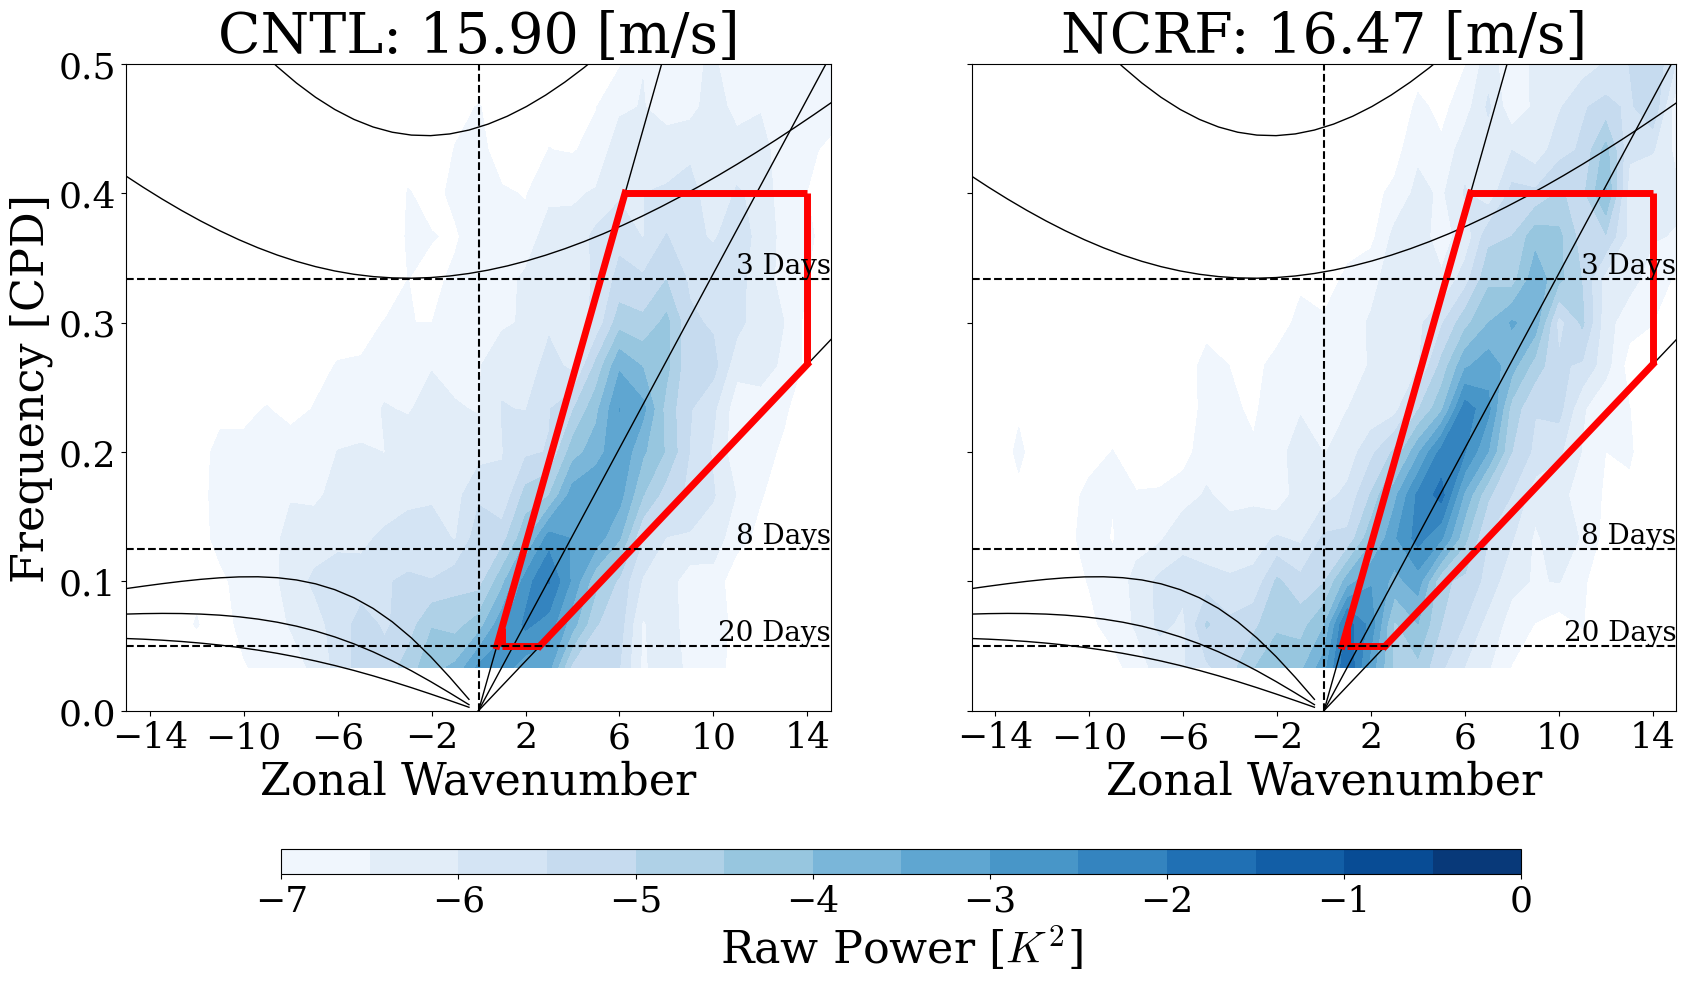

In [7]:
plt.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "axes.titlesize": 40,
    "axes.labelsize": 32,
    "xtick.labelsize": 26,
    "ytick.labelsize": 26,
    "figure.figsize": (20, 12),
});

wn_v: np.ndarray = np.fft.fftshift(wn);
fr_v: np.ndarray = np.fft.fftshift(fr);

fig, ax = plt.subplots(1, 2, sharey=True);

cntl_raw = ax[0].contourf(
    wn_v,
    fr_v[fr_v>0],
    np.log(np.fft.fftshift(sym_ps_weight["cntl"])[fr_v>0]*2.0),
    levels=np.linspace(-7, 0, 15),
    cmap="Blues"
);
plot_lines(ax[0], wn_ana, fr_ana);
ax[0].set_xlim(-15, 15);
ax[0].set_ylim(0, 0.5);
ax[0].set_title(f"CNTL: {cntl_speed:.2f} [m/s]");
ax[0].set_xlabel("Zonal Wavenumber");
ax[0].set_ylabel("Frequency [CPD]");

ncrf_raw = ax[1].contourf(
    wn_v,
    fr_v[fr_v>0],
    np.log(np.fft.fftshift(sym_ps_weight["ncrf"])[fr_v>0]*2.0),
    levels=np.linspace(-7, 0, 15),
    cmap="Blues"
);
plot_lines(ax[1], wn_ana, fr_ana);
ax[1].set_xlim(-15, 15);
ax[1].set_ylim(0, 0.5);
ax[1].set_title(f"NCRF: {ncrf_speed:.2f} [m/s]");
ax[1].set_xlabel("Zonal Wavenumber");

plt.colorbar(
    cntl_raw, ax=ax,
    orientation="horizontal",
    shrink=0.8, aspect=50,
    label=r"Raw Power [$K^2$]"
);
plt.savefig("/home/b11209013/Bachelor_Thesis/Figure/NCRF_raw_power.png")

#### Normalized spectrum

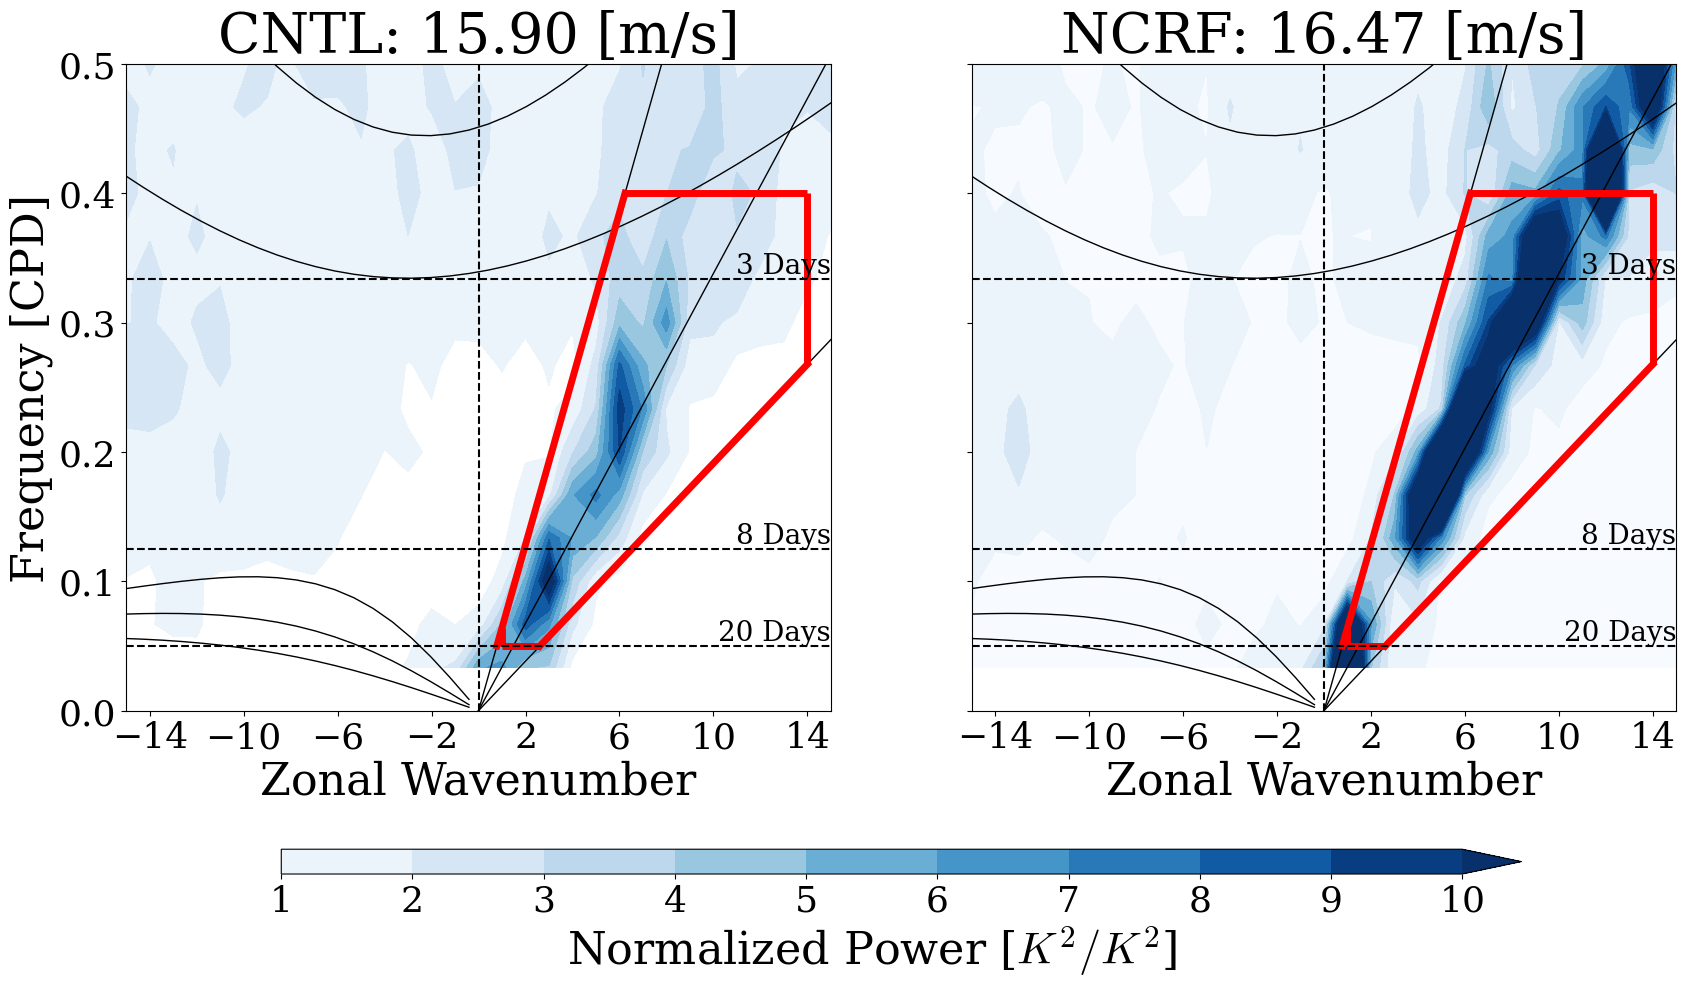

In [11]:
fig, ax = plt.subplots(1, 2, sharey=True);

cntl_raw = ax[0].contourf(
    wn_v,
    fr_v[fr_v>0],
    sym_peak["cntl"][fr_v>0],
    levels=np.linspace(1, 10, 10),
    cmap="Blues", extend="max"
);
plot_lines(ax[0], wn_ana, fr_ana);
ax[0].set_xlim(-15, 15);
ax[0].set_ylim(0, 0.5);
ax[0].set_title(f"CNTL: {cntl_speed:.2f} [m/s]");
ax[0].set_xlabel("Zonal Wavenumber");
ax[0].set_ylabel("Frequency [CPD]");

ncrf_raw = ax[1].contourf(
    wn_v,
    fr_v[fr_v>0],
    sym_peak["ncrf"][fr_v>0],
    levels=np.linspace(1, 10, 10),
    cmap="Blues", extend="both"
);
plot_lines(ax[1], wn_ana, fr_ana);
ax[1].set_xlim(-15, 15);
ax[1].set_ylim(0, 0.5);
ax[1].set_title(f"NCRF: {ncrf_speed:.2f} [m/s]");
ax[1].set_xlabel("Zonal Wavenumber");

plt.colorbar(
    cntl_raw, ax=ax,
    orientation="horizontal",
    shrink=0.8, aspect=50,
    label=r"Normalized Power [$K^2/K^2$]"
);
plt.savefig("/home/b11209013/Bachelor_Thesis/Figure/NCRF_norm_power.png")